### Preliminars

##### Imports

In [41]:
import scipy as sci
from scipy import stats
from scipy.special import expit
import pandas as pd
import numpy as np
from numpy.linalg import inv
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools as iter
%matplotlib widget


##### Misc

In [42]:
np.random.seed(69)

def set_axis_labels(ax, x, y, z=None):
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    if z != None:
        ax.set_zlabel(z)


### Definitions

##### Norms

In [43]:
norm_names = [
    "Euclidean2",
    "Manhattan",
    "Infinity",
    "Mahalanobis2"
]

norm = dict(zip(norm_names, [
    lambda x: np.sum(x**2, axis=0,),
    lambda x: np.sum(np.abs(x), axis=0),
    lambda x: np.max(np.abs(x), axis=0),
    lambda S: lambda x: np.squeeze(np.concatenate(
        [c[None, :] @ inv(S) @ c[:, None] for c in x.T]))
]))

def dist_matrix(X, Y, norm=norm["Euclidean2"]):
    D = np.zeros((X.shape[1], Y.shape[1]))
    for x, y in iter.product(range(X.shape[1]), range(Y.shape[1])):
        D[x, y] = norm(X[:, x] - Y[:, y])
    return D

##### PDFs

In [44]:
pdf_names = ["Uniform", "Triangular", "Normal"]


def pdf(pdf, x, N):
    return pd.Series(dict(zip(pdf_names, [
        sci.stats.uniform.pdf(x, 0, N),
        sci.stats.triang.pdf(x, 0.5, -1, N+1),
        sci.stats.norm.pdf(x, N//2, N//6)])
    )[pdf], index=x)

##### Learner measures

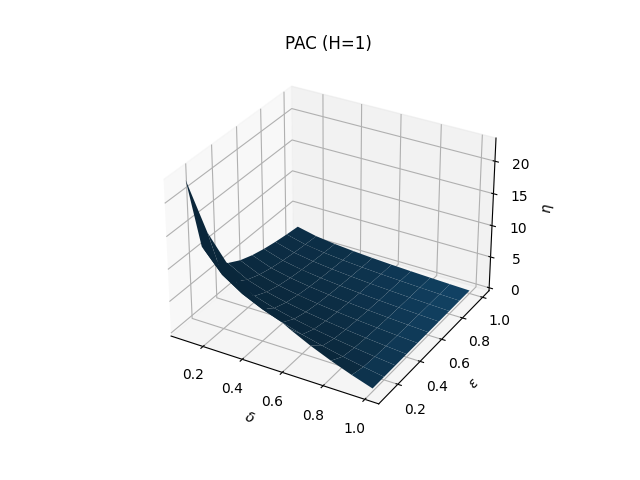

In [45]:
# lower bound to sample size
def PAC_eta(H_norm, delta, epsilon):
    return (np.log(H_norm) - np.log(delta))/epsilon

# lower bound to generalization error
def PAC_delta(H_norm, epsilon, eta):
    return H_norm/np.exp(eta*epsilon)

H = 1
plt.figure()
X = Y = np.linspace(0.1, 1, 10)
X, Y = np.meshgrid(X, Y)
ax = plt.axes(projection='3d', title=f'PAC (H={H})')
ax.plot_surface(X, Y, PAC_eta(H, X, Y))
set_axis_labels(ax, '$\\delta$', '$\\varepsilon$', '$\\eta$')
#print(X,Y)


### Data Retrieval

##### Read Data

In [46]:
classify = True
if classify:
    file = 'iris.csv'
    index_col, header = 0, 0
else:
    file = 'examen.csv'
    index_col, header = None, None
data = pd.read_csv(file, index_col=index_col, header=header).reset_index(drop=True)
N_S = len(data.index)
indices = data.index

##### Preprocessing

In [47]:
def normalize(points):
    min = points.min(axis=1, keepdims=True)
    scale = points.max(axis=1, keepdims=True) - min
    def denormalize(points): return points * scale + min
    return (points - min) / scale, denormalize


def label_to_int(data):
    data = data.iloc[:, 0]
    labels = data.unique()
    label_map = dict(zip(labels, range(len(labels))))
    return data.apply(lambda x: label_map[x]), labels


def vectorize(data):
    I = np.identity(np.max(data) + 1)
    return np.array([I[:, c] for c in data.T]).T


X_S, Y_S = data.iloc[:, :-1], data.iloc[:, [-1]]
X_S, denormalize_X = normalize(X_S.to_numpy().T)

if classify:
    Y_S, labels = label_to_int(Y_S)
    Y_S = vectorize(Y_S.to_numpy().T)
else:
    Y_S, denormalize_Y = normalize(Y_S.to_numpy().T)


# Sampling

##### Distribution Comparison (PDF)

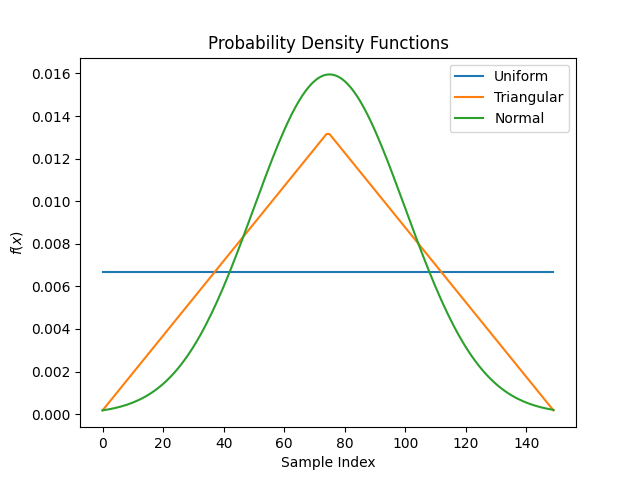

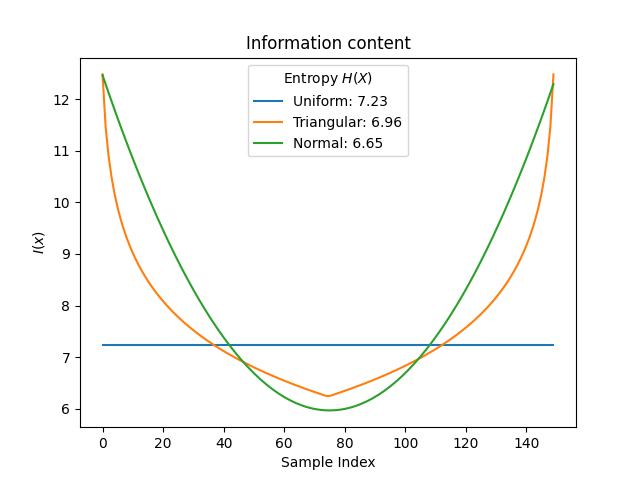

In [48]:
plt.figure()
ax = plt.axes(title="Probability Density Functions")
for name in pdf_names:
    F = pdf(name, indices, N_S)
    ax.plot(indices, F, label=name)
plt.legend()
set_axis_labels(ax, "Sample Index", "$f(x)$")

plt.figure()
ax = plt.axes(title="Information content")
for name in pdf_names:
    F = pdf(name, indices, N_S)
    I = np.log2(1/F)
    H = np.sum(-F*np.log2(F))
    plt.plot(indices, I, label=f"{name}: {H:.2f}")
plt.legend(title="Entropy $H(X)$")
set_axis_labels(ax, "Sample Index", "$I(x)$")


##### Distribution Comparison (Sample)

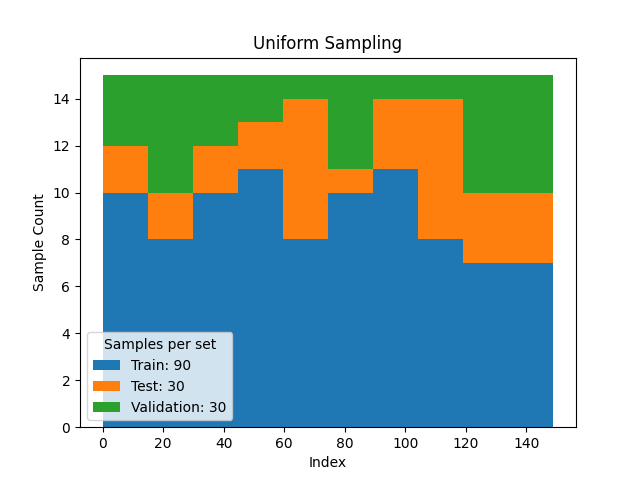

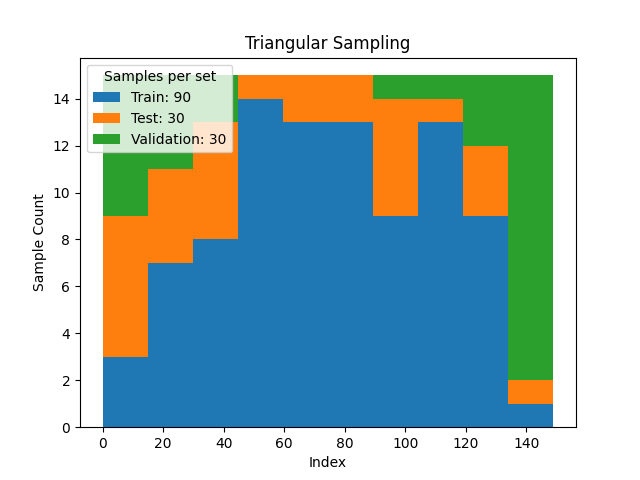

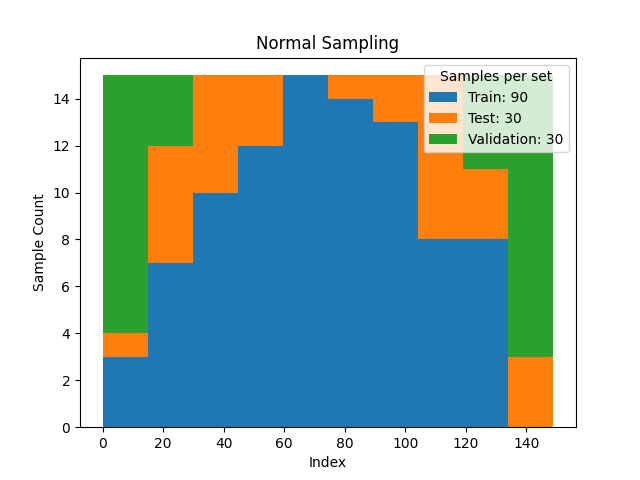

In [49]:
sets = {"Train": int(0.6*N_S),
        "Test": int(0.2*N_S),
        "Validation": int(0.2*N_S)}

sets_S = sets.copy()

for name in pdf_names:
    weights = pdf(name, indices, N_S)
    sets_curr = sets.copy()
    plt.figure()
    ax = plt.axes(title=f"{name} Sampling")
    
    for k, v in sets_curr.items():
        sample = np.random.choice(weights.index, size=v, p=weights/weights.sum(), replace=False)
        sets_curr[k] = sample
        if name == "Uniform":
            sets_S[k] = (X_S[:, sample], Y_S[:, sample])
        weights = weights.drop(sample)

    ax.hist(sets_curr.values(), stacked=True, bins=10,
        label=[f"{k}: {len(v)}" for k, v in sets_curr.items()]) 
    set_axis_labels(ax, 'Index', 'Sample Count')   
    plt.legend(title="Samples per set")

# Supervised Learning

### Neural Network

##### Definition

In [104]:
def softmax(x): return np.exp(x) / np.sum(np.exp(x), axis=0)
def dsoftmax(x): return softmax(x) * (np.eye(x.shape[0]) - softmax(x).T)

def feedforward(X, phi, dphi, W, B=None, classify=False, Yd = None, full=False):
    k = len(W) - 1
    V = [None] * (k+1)
    Y = [None] * (k+1)
    Y[0] = X
    for l in range(1, k+1):
        V[l] = W[l] @ Y[l-1]
        if B != None:
            V[l] += B[l]
        Y[l] = phi(V[l])
    if classify:
        Y[k] = softmax(V[k])
    if Yd is not None:
        dE = Y[k] - Yd
        E = np.average(norm["Euclidean2"](Y[k] - Yd))/2
    if full:
        return Y, V, E, dE
    else:
        return Y[k], E
    

def update(X, Yd, phi, dphi, W, B=None, classify=False):
    p = X.shape[1]
    k = len(W) - 1

    # feedforward
    Y, V, E, dE = feedforward(X,phi, dphi, W, B, classify, Yd, full=True)
    
    # backpropagation
    delta = [None] * (k+1)
    if classify:
        delta[k] = np.concatenate([dsoftmax(V[k][:, [c]]) @ dE[:, [c]]
            for c in range(p)], axis=1)
    else:
        delta[k] = dphi(V[k]) * dE

    for l in reversed(range(1, k)):
        delta[l] = (W[l+1].T @ delta[l+1]) * dphi(V[l])

    # update

    for l in range(1, k+1):
        W[l] -= (delta[l] @ Y[l-1].T) / p
        if B != None:
            B[l] -= (delta[l] @ np.ones((p, 1))) / p
    return delta, E, W, B


##### Run

In [109]:
X, Yd = sets_S["Train"]
X_test, Yd_test = sets_S["Test"]

neurons = [X.shape[0], 2, 2, Yd.shape[0]]
k = len(neurons) - 1
epochs = 1000

W = [None] * (k+1)
B = [None] * (k+1)
for l in range(1, k+1):
    W[l] = np.random.randn(neurons[l], neurons[l-1])
    B[l] = np.random.randn(neurons[l])[:, None]

sigmoid = expit
dsigmoid = lambda x: sigmoid(x) * (1 - sigmoid(x))

deltas = []
errors = {"Train": [],
          "Test": [],
          "Validation": []}
ys = []
for i in range(epochs):
    Y_test, E_test = feedforward(X_test, sigmoid, dsigmoid, W, B, classify, Yd_test)
    ys.append([Y_test])
    errors["Test"].append(E_test)
    
    delta, E_train, W, B = update(X, Yd, sigmoid, dsigmoid, W, B, classify)
    deltas.append([np.mean(norm["Manhattan"](delta[l]), axis=0)
        for l in range(1, k+1)])  
    errors["Train"].append(E_train)

deltas = np.array(deltas).T

##### Graphs

C:\Users\Orfy\AppData\Local\Temp\ipykernel_9036\2498873929.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


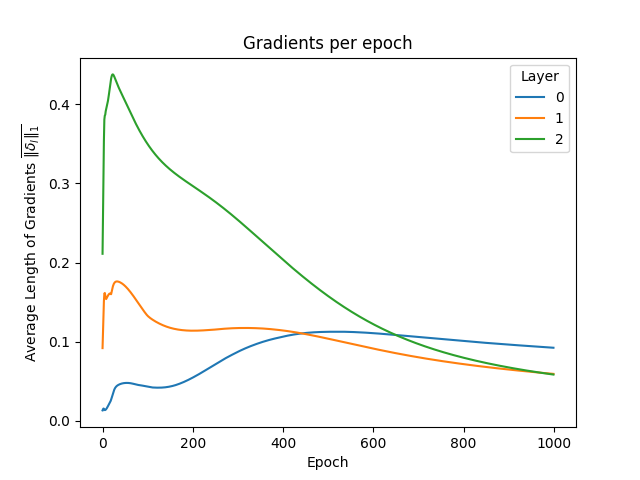

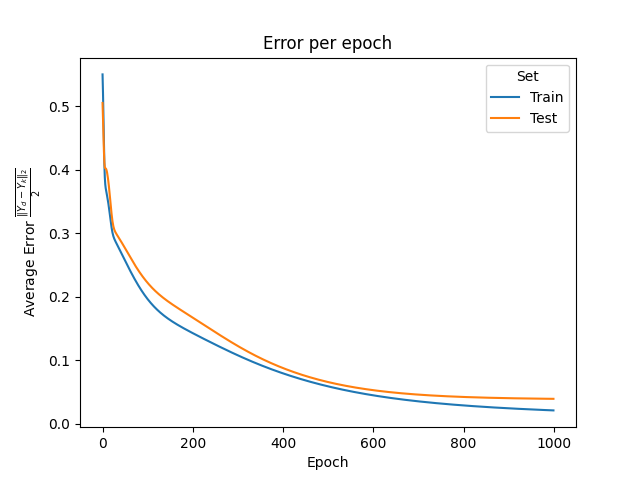

In [110]:
plt.figure()
ax = plt.axes(title=f"Gradients per epoch")
ax.plot(range(epochs), deltas.T, label=range(deltas.shape[0]))
ax.legend(title="Layer")
set_axis_labels(ax, "Epoch", 
    "Average Length of Gradients $\\overline{\\Vert\\delta_l\\Vert_1}$")

plt.figure()
ax = plt.axes(title=f"Error per epoch")
ax.plot(range(epochs), errors["Train"], label="Train")
ax.plot(range(epochs), errors["Test"], label="Test")
plt.legend(title="Set")
set_axis_labels(ax, "Epoch",
    "Average Error $\\frac{\\overline{\\Vert Y_d - Y_k\\Vert_2}}{2}$")

if not classify:
    plt.figure()
    plot_N = 11
    cmap = plt.get_cmap("inferno_r", plot_N)
    ticks = np.linspace(0, len(ys)-1, plot_N, dtype=int)
    ax = plt.axes(projection="3d", title=f"Output comparison")
    ax.scatter(X_test[0, :], X_test[1, :], Y_test, label="Reference", color = 'darkred')
    for c, k in enumerate(ticks):
        ax.scatter(X_test[0, :], X_test[1, :], ys[k][0], color = cmap(c))

    plt.legend()
    norm = mpl.colors.Normalize(vmin=0, vmax=len(ys))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    cbar = plt.colorbar(sm, ticks=ticks+1, ax=ax)
    cbar.ax.set_yticklabels(ticks+1)
    cbar.set_label("Epoch")
    set_axis_labels(ax, "$X_0$", "$X_1$", "$Y_0$")


# Unsupervised Learning

### Norms

In [ ]:
norm_names = [
    "Euclidean2",
    "Manhattan",
    "Infinity",
    "Mahalanobis2"
]

norm = dict(zip(norm_names, [
    lambda x: np.sum(x**2, axis=0,),
    lambda x: np.sum(np.abs(x), axis=0),
    lambda x: np.max(np.abs(x), axis=0),
    lambda S: lambda x: np.squeeze(np.concatenate(
        [c[None, :] @ inv(S) @ c[:, None] for c in x.T]))
]))

def dist_matrix(X, Y, norm=norm["Euclidean2"]):
    D = np.zeros((X.shape[1], Y.shape[1]))
    for x, y in iter.product(range(X.shape[1]), range(Y.shape[1])):
        D[x, y] = norm(X[:, x] - Y[:, y])
    return D

### K-means

In [ ]:
def cost_intracluster(X, C, norm):
    return np.sum(norm(X-C))

def cost(X, C, norm):
    acum = 0
    for c in range(len(C)):
        acum += cost_intracluster(X[:, C[c][1]], C[c][0], norm)
    return acum


def update_clusters(C, X):
    U = [[] for i in range(C.shape[0])]
    for x, c in enumerate(np.argmax(dist_matrix(C, X), axis=0)):
        U[c].append(x)
    return U

def update_centers(U, X):
    C = np.concatenate([np.sum(X[:, u], axis=1, keepdims=True)/len(u)
        for u in U], axis=1)
    return C

def k_means(k, X):
    U = np.random.choice(np.linspace(0, X.shape[1]-1, dtype=int), k)
    C = X[:, U]
    U = update_clusters(C, X)
    print(U)
    C = update_centers(U, X)
    print(C)

softmax = lambda x: np.exp(x) / np.sum(np.exp(x), axis=0)
dsoftmax = lambda x: softmax(x) * (np.eye(x.shape[0]) - softmax(x).T)
A = np.array([[1, 2]]).T
B = np.array([[2, 1/2]]).T
print(A @ B)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 1)